In [23]:
# %pip install torch
# %pip install pymoo
# %pip install pywin32

In [24]:
import os, sys

# Get the absolute path of the notebook's directory
notebook_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

# Add the parent directory to sys.path so we can import modules
sys.path.append(parent_dir)

# Verify the path
print(f"Added to sys.path: {parent_dir}")

# Add it to sys.path
sys.path.append(parent_dir)

print(parent_dir)
from localityaware.module import *
from NSGA_nn.nsga import *
from Vinyl_Distillation.VCDistillationDummy import MultiTestDummy

Added to sys.path: /Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen
/Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen


In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import time

# Define the file path for saving/loading the data
data_file = "vcdistil.pkl"



print("Generating new data...")
assSim = MultiTestDummy(AspenFile="Vinyl Chloride Distillation.bkp", 
                        wdpath="../Vinyl_Distillation", 
                        visibility=False)

Generating new data...
MultiTestDummy: Initialized dummy simulation for multitest equation. No Aspen calls will be made.


In [26]:
import numpy as np
from scipy.stats import qmc

# Number of samples you want to generate
N = 100  # Adjust as needed

# Define lower and upper bounds for the 2 decision variables for the MultiTestDummy
lower_bounds = np.array([-2, -2])
upper_bounds = np.array([2, 2])

# Initialize the Latin Hypercube Sampler for 2 dimensions.
sampler = qmc.LatinHypercube(d=2)
sample_unit = sampler.random(n=N)  # Samples in [0, 1) with shape (N,2)

# Scale the samples to the desired parameter ranges.
samples_scaled = qmc.scale(sample_unit, lower_bounds, upper_bounds)

# For debugging: print the first few samples.
print("First 5 LHS samples (each row corresponds to [x1, x2]):")
print(samples_scaled[:5])

First 5 LHS samples (each row corresponds to [x1, x2]):
[[-0.46150868  0.01354878]
 [-0.10587731  1.75137133]
 [ 0.68922358 -0.73100191]
 [ 0.97689407  1.57527209]
 [ 0.35893783 -0.91155006]]


(100, 2)


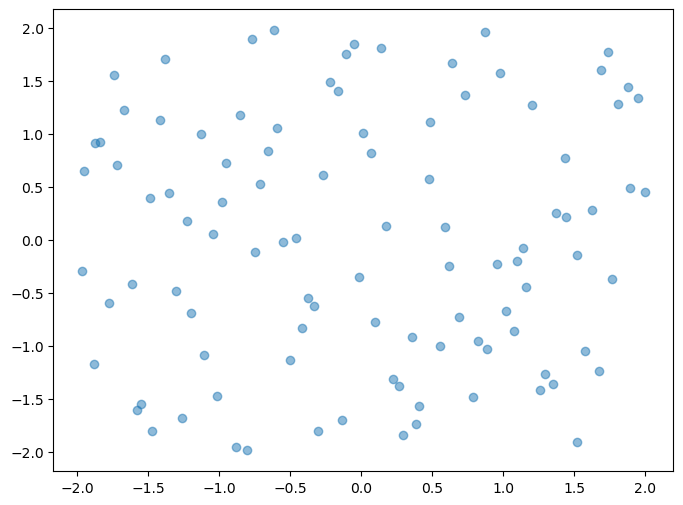

In [27]:
import numpy as np
import matplotlib.pyplot as plt

X_params = samples_scaled[:, :8]
print(X_params.shape)
# (N, 2) # plot in 2D only 2 var no CPA

# Plotting the first two parameters
plt.figure(figsize=(8, 6))
plt.scatter(X_params[:, 0], X_params[:, 1], alpha=0.5)

In [28]:
# Start timing the data generation (simulation evaluations)
start_time = time.time()

data_sim = []

for param_array in samples_scaled:
    # Convert the 8 parameters into the expected input format
    x_unflat = assSim.unflatten_params(param_array)
    # Run the objective function (this is where the Aspen or dummy simulation is called)
    cost = assSim.run_obj(x_unflat)
    # Save the parameters and cost together; you can store as [p1, p2, ..., p8, cost]
    # print(cost)
    data_sim.append(list(param_array) + list(cost))
print("shape of data_sim", np.array(data_sim).shape)

shape of data_sim (100, 4)


In [29]:
data_sim = np.array(data_sim)
elapsed = time.time() - start_time
print(f"Generated {len(data_sim)} simulation points in {elapsed:.2f} seconds.")

# Save the dataset if needed (for example, to a pickle file)
# import pickle
# with open("distillation_data_sim.pkl", "wb") as f:
#     pickle.dump({"data": data_sim, "time_sec": elapsed}, f)

data_sim = np.array(data_sim)
data_gen_time = time.time() - start_time  # Total time to generate data
total_original_assSim_calls = len(data_sim)

Generated 100 simulation points in 0.02 seconds.


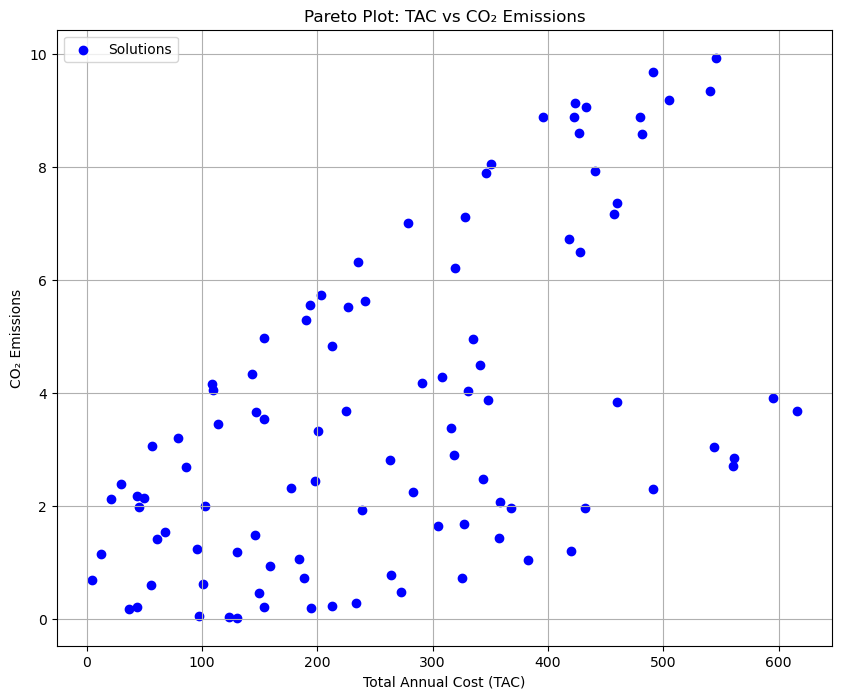

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Replace this with your actual data.
objectives = data_sim[:, -2:]  # Assuming the last two columns are the objectives
plt.figure(figsize=(10, 8))
plt.scatter(objectives[:, 0], objectives[:, 1], color='blue', marker='o', label="Solutions")
plt.xlabel('Total Annual Cost (TAC)')
plt.ylabel('CO₂ Emissions')
plt.title('Pareto Plot: TAC vs CO₂ Emissions')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
print(len(data_sim))

# Instantiate the scaler with provided ranges for 2-D inputs and 2-D outputs.
scaler = TorchMinMaxScaler(
    feature_range=(-1, 1), 
    max_vals=[2, 2],      # Decision variables x1, x2 range in [-2,2]
    min_vals=[-2, -2],
    scale_y=True,
    min_y=[0, 0],         # Assume output min for f1 and f2 is 0
    max_y=[900, 15]       # Approximate output max: f1 near 800 (margin to 900), f2 near 13-15
)

# Here, data_sim is assumed to be a NumPy array of shape (N, 4) where:
# the first 2 columns are the decision variables,
# and the last 2 columns are the corresponding objective values.
# For scaling, we use:
data_sim_xscaled, data_sim_yscaled = scaler.transform(data_sim[:, :2], data_sim[:, 2:])

# Convert the resulting PyTorch tensors to NumPy arrays.
data_sim_xscaled = data_sim_xscaled.detach().cpu().numpy()
data_sim_yscaled = data_sim_yscaled.detach().cpu().numpy()

# Check shapes for debugging:
print("Shape of scaled inputs:", data_sim_xscaled.shape)   # should be (N, 2)
print("Shape of scaled outputs:", data_sim_yscaled.shape)    # should be (N, 2)

# Recombine scaled inputs and outputs into one array with 4 columns (2 + 2).
data_sim_scaled = np.column_stack([data_sim_xscaled, data_sim_yscaled])
print("Shape of combined scaled data:", data_sim_scaled.shape)

# **Initialize Model & Dataset**
# The DynamicDataset class should now be initialized with num_inputs=2.
dataset = DynamicDataset(data_sim_scaled, num_inputs=2)
# Initialize an MLP with 2 input neurons and 2 output neurons; adjust hidden layers as desired.
model = MLP(2, [50, 50, 20, 50, 50], 2)

print("Dataset and model initialized.")
#check dataset dimensions 

100
Shape of scaled inputs: (100, 2)
Shape of scaled outputs: (100, 2)
Shape of combined scaled data: (100, 4)
Dataset and model initialized.


In [32]:
from Vinyl_Distillation.VCDistillationDummy import MultiTestProblem
problem = MultiTestProblem(model)

In [33]:
out = optimize_surr_nsga(model=model,
                   dataset=dataset,
                   assSim=assSim,
                   problem=problem,
                   lrs={'first':1e-3, 'others':1e-3},
                   epochs={'first':400, 'others':200},
                   min_vals=scaler.min_x,
                   max_vals=scaler.max_x,
                   scaler=scaler,
                   device='cpu',
                   iter=5,
                   print_loss=True,
                   print_it_data=True,
                   pop_size=200,
                   n_gen = 5,
                   new_data_size=0,
                   batch_size=512
                   )

Iteration 0: Training surrogate model...
Epoch 0: Total Loss=0.3499
Epoch 50: Total Loss=0.0580
Epoch 100: Total Loss=0.0007
Epoch 150: Total Loss=0.0002
Epoch 200: Total Loss=0.0001
Epoch 250: Total Loss=0.0001
Epoch 300: Total Loss=0.0001
Epoch 350: Total Loss=0.0001
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |      3 |  0.000000E+00 |  1.604870E+01 |             - |             -
     2 |      400 |      5 |  0.000000E+00 |  0.9964831767 |  0.0056877509 |         ideal
     3 |      600 |      7 |  0.000000E+00 |  0.0000276063 |  0.1399925417 |         ideal
     4 |      800 |     11 |  0.000000E+00 |  0.000000E+00 |  0.1035710695 |         ideal
     5 |     1000 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0350922357 |         ideal
optim_input_scaled.shape: (21, 2)
optim_input_scaled: [[ 0.29172116 -0.00476351]
 [ 0.11367796  0.03755062]
 [ 0.15926328 -0.0109392 ]
 [ 0.3315718   0.0401453 ]
 [ 0.15926328 -0.05098

In [34]:
import os
import datetime
import pickle

print(os.getcwd())
# Get current notebook name manually (or hardcode it here)
notebook_name = "multitest"  # or os.path.basename(__file__).replace(".py", "")

# Get timestamp
now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Construct path: results/<notebook_name>/run_<timestamp>/
base_dir = os.path.join("../NSGA_nn/results", notebook_name)
save_dir = os.path.join(base_dir, f"run_{now}")
os.makedirs(save_dir, exist_ok=True)
print(save_dir)

print(f"Results will be saved in: {save_dir}")

# Save out.pkl
out["data_gen_time"] = data_gen_time
out["total_original_assSim_calls"] = total_original_assSim_calls
with open(os.path.join(save_dir, "out.pkl"), "wb") as f:
    pickle.dump(out, f)

# Save scaler
with open(os.path.join(save_dir, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

# Save dataset
with open(os.path.join(save_dir, "dataset.pkl"), "wb") as f:
    pickle.dump(dataset, f)

print(f"Saved all results in {save_dir}")


/Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen/NSGA_nn
../NSGA_nn/results/multitest/run_2025-04-14_15-17-27
Results will be saved in: ../NSGA_nn/results/multitest/run_2025-04-14_15-17-27
Saved all results in ../NSGA_nn/results/multitest/run_2025-04-14_15-17-27
